In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import seaborn as sns
import helper
import os
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

- Fitted parameters per participant
- Uncertainty estimates for fitted parameters
- Compare models using the same plots as in the main paper
-- p_go
-- RT
-- RT distributions
- Compare models using predictive metrics
-- ROC of p_go per participant
-- R-squared of RT per participant
-- ROC and R-squared for cross-validation

In [3]:
exp_measures = pd.read_csv("../data/measures.csv")
exp_data = pd.read_csv("../data/processed_data.csv", index_col=["subj_id", "session", "route", "intersection_no"])
model_params = pd.read_csv("../model_fit_results/model_1/best_fit_parameters/full_data_parameters_fitted.csv")
simulation_results_path = "../model_fit_results/model_1/simulation_results/"
model_measures_all_conditions = pd.read_csv(os.path.join(simulation_results_path, "full_data_measures.csv"))

# Fitted parameter values

In [3]:
def plot_fitted_params(model_params):
    fig, axes = plt.subplots(1, 8, dpi=100, figsize=(8,3))
    params_to_plot = model_params.drop(columns=["tta_condition", "d_condition", "loss"]).set_index("subj_id")
    param_display_names = ["$\\alpha$", "$\\beta$", "$\\theta_{crit}$", "$b_0$", "$k$", "$\\tau$", "$\\mu_{ND}$", "$\\sigma_{ND}$"]

    for param_name, display_name, ax in zip(params_to_plot.columns, param_display_names, axes.flatten()):
        param_values = params_to_plot.loc[~(params_to_plot.index.get_level_values(level="subj_id")=="all"), param_name]
        sns.stripplot(ax=ax, data=param_values, color="C0")
        sns.stripplot(ax=ax, data=[params_to_plot.loc["all", param_name]], marker="s", size=6, color="C1")
        sns.boxplot(ax=ax, data=param_values, whis=[0, 100], linewidth=0.5, boxprops=dict(alpha=.1))
        ax.set_xlabel(display_name)
        ax.get_xaxis().set_ticks([])
        ax.spines["left"].set_alpha(0.3)

    legend_elements = ([Line2D([0], [0], color="C0", marker="o", ms=4, ls="", label="- inividual participants"),
                        Line2D([0], [0], color="C1", marker="s", ms=6, ls="", label="- all participants")])
    legend = fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.99, 0.5), fontsize=14, frameon=False)
    legend.set_title("Model fitted to", prop={"size":16})

    sns.despine(bottom=True, offset=2)
    fig.text(-0.02, 0.2, "Parameter value", fontsize=16, rotation=90)

    plt.tight_layout()

    params_to_export = params_to_plot.reset_index()
    params_to_export.columns = ["Participant", "$\\alpha$", "$\\beta$", "$\theta_{\textrm{crit}}$", "$b_0$",
                                "$k$", "$\tau$", "$\mu_{\textrm{ND}}$", "$\sigma_{\textrm{ND}}$"]
    params_to_export["Participant"] = range(len(params_to_export))
    params_to_export["Participant"] += 1
    params_to_export.iloc[-1, 0] = "all"

    with open("../output/tab_SI_params.tex", "w") as tf:
        tf.write(params_to_export.to_latex(float_format="%.2f", escape=False, index=False))

    return params_to_export

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_11660\2091293898.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(params_to_export.to_latex(float_format="%.2f", escape=False, index=False))


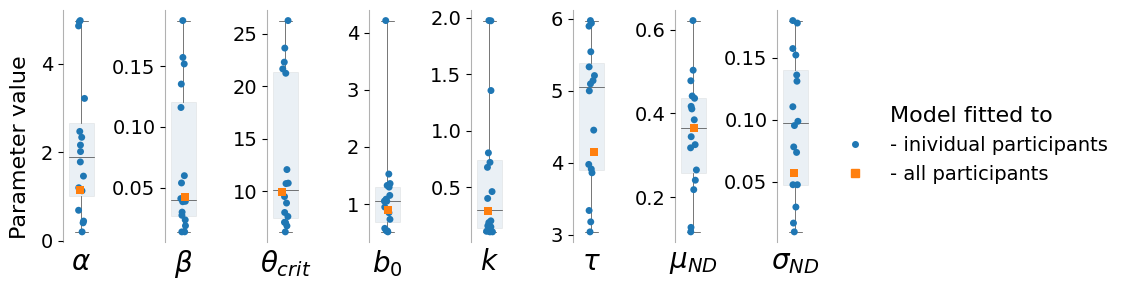

In [4]:
params_to_export = plot_fitted_params(model_params)
plt.savefig("../output/fig_SI_params.png", bbox_inches="tight")

In [5]:
params_to_export

,Participant,$\alpha$,$\beta$,$\theta_{\textrm{crit}}$,$b_0$,$k$,$\tau$,$\mu_{\textrm{ND}}$,$\sigma_{\textrm{ND}}$
0,1,1.465101,0.018664,6.680473,1.358825,1.356360,3.860662,0.264850,0.047674
1,2,2.166484,0.038774,9.472298,4.212950,0.719124,5.941149,0.240345,0.009653
2,3,2.474682,0.053874,12.043280,0.529389,0.107809,4.999867,0.503477,0.136171
3,4,0.205143,0.187549,26.239770,1.150890,0.156334,4.453769,0.217725,0.016763
4,5,1.133518,0.027239,7.574977,1.051087,0.102798,3.976779,0.127398,0.073737
5,6,2.019625,0.041021,10.751197,0.848347,0.200491,5.333476,0.478199,0.110586
6,7,1.202551,0.029875,7.956272,1.325787,0.803443,3.336020,0.116699,0.047683
7,8,0.409683,0.135284,21.634810,1.296452,0.184983,5.142172,0.325358,0.178058
8,9,1.785406,0.013604,6.981798,1.085588,0.109460,3.038809,0.622211,0.157499
9,10,0.449293,0.151842,22.277862,1.049106,0.399266,5.212551,0.317776,0.095404


# Uncertainty of parameter estimates

To find out if the identified model parameters are reliable, we check if the values of the parameters change when we repeat the fitting procedure 10 times. Because fitting takes a lot of time (around 2-3 hours per fit on an i7 CPU), we do this only for two participants. We chose the participants with the highest and the lowest value of the loss function (P15 and P16, respectively).

In [6]:
repeated_fit_param_path = "../model_fit_results/model_1/best_fit_parameters/full_data_repeated/"

repeated_fit_params = pd.concat([pd.read_csv(os.path.join(repeated_fit_param_path, file_name)) for file_name in os.listdir(repeated_fit_param_path)]).reset_index(drop=True)
repeated_fit_params = repeated_fit_params.drop(columns=["tta_condition", "d_condition", "loss"])
repeated_fit_params.loc[repeated_fit_params.subj_id==969, "subj_id"] = 15
repeated_fit_params.loc[repeated_fit_params.subj_id==996, "subj_id"] = 16
repeated_fit_params = repeated_fit_params.melt(id_vars=["subj_id", "n"]).rename(columns={"subj_id": "Participant", "variable": "parameter"})

In [7]:
def plot_fitted_params_repeated(params):
    fig, axes = plt.subplots(1, 8, dpi=100, figsize=(8,3), sharex=True, sharey=False)

    param_display_names = ["$\\alpha$", "$\\beta$", "$\\theta_{crit}$", "$b_0$", "$k$", "$\\tau$", "$\\mu_{ND}$", "$\\sigma_{ND}$"]

    for param_name, display_name, ax in zip(params.parameter.unique(), param_display_names, axes.flatten()):
        params_to_plot = params[params.parameter==param_name]
        with sns.color_palette("viridis"):
            sns.stripplot(ax=ax, data=params_to_plot, x="Participant", y="value", )
            sns.boxplot(ax=ax, data=params_to_plot, x="Participant", y="value", whis=[0, 100], linewidth=0.5, boxprops=dict(alpha=.3))
        ax.set_xlabel(display_name)
        ax.get_xaxis().set_ticks([])
        ax.set_ylabel("")
        ax.spines["left"].set_alpha(0.3)

    legend_elements = ([Line2D([0], [0], color=sns.color_palette("viridis")[0], marker="o", ls="", label="P15"),
                            Line2D([0], [0], color=sns.color_palette("viridis")[1], marker="o", ls="", label="P16")])
    fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.99, 0.5), frameon=False)
    # legend = fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.99, 0.5), fontsize=14, frameon=False)
    # legend.set_title("Model fitted to", prop={"size":16})

    sns.despine(bottom=True, offset=2)
    fig.text(-0.02, 0.2, "Parameter value", fontsize=16, rotation=90)

    plt.tight_layout()

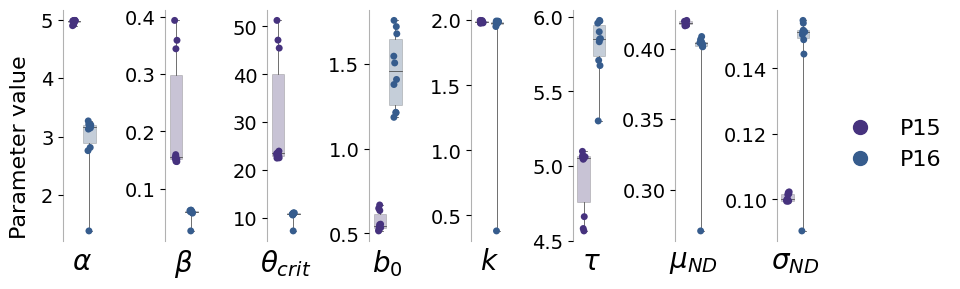

In [8]:
plot_fitted_params_repeated(repeated_fit_params)
plt.savefig("../output/fig_SI_params_repeated_fit.png", bbox_inches="tight")

# Comparison to simpler evidence accumulation models

In [8]:
all_models_best_fit_params_path = "../model_fit_results/model_%i/best_fit_parameters/%s_parameters_fitted.csv"
all_models_simulation_results_path = "../model_fit_results/model_%i/simulation_results/%s_measures.csv"

In [10]:
model_measures = [pd.read_csv(all_models_simulation_results_path % (model_no, "full_data")) for model_no in [1, 2, 3]]

### Decision probabilities and mean RTs

In [11]:
def plot_compare_models(var, exp_data, ylabel):
    #because of a bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({"subj_id": str})

    model_measures = [pd.read_csv(all_models_simulation_results_path % (model_no, "full_data")) for model_no in [1, 2, 3]]
    model_measures = [df[(df.tta_condition>=4.0) & (df.tta_condition<=6.0)] for df in model_measures]

    d_conditions = [90, 120, 150]
    markers=["o", "s", "^"]

    subjects = model_measures[0].subj_id.unique()

    fig, axes = plt.subplots(4, 5, figsize=(14,12), sharex=True, sharey=True)

    axes_to_plot = np.concatenate([axes[:,:4].flatten(), [axes[0,4]]])
    for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes_to_plot):
        ax.set_title("All participants" if subj_id=="all" else "P%s" % (subj_idx+1), fontsize=16)

        for d_condition, marker in zip(d_conditions, markers):
            # Models
            for model_no in [1, 2, 3]:
                model_subj_d_measures = model_measures[model_no-1][(model_measures[model_no-1].subj_id==subj_id)
                                                       & (model_measures[model_no-1].d_condition==d_condition)]

                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], color="C%i" % (model_no-1))

            if var=="is_go_decision":
                # for all subjects, use scipy sem estimates, since we average over continuous measures (p_go)
                if subj_id=="all":
                    helper.plot_all_subj_p_go(ax, exp_data, d_condition, marker, color="grey")
                # for individual subjects, use binomial proportion sem estimates, since we average over binary measures (is_go_decision)
                else:
                    helper.plot_subj_p_go(ax, exp_data, d_condition, subj_id, marker, color="grey")
            elif var=="RT":
                helper.plot_subj_rt(ax, exp_data, d_condition, subj_id, marker, color="grey")
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])
            else:
                raise(ValueError)

        ax.set_xlabel("")
        ax.set_ylabel("")

    sns.despine(offset=5, trim=True)

    for ax in axes[1:,4]:
        fig.delaxes(ax)

    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color="grey", marker=marker, ms=9, lw=0, label="Data, d=%im" % (d_condition))
                       for d_condition, marker in zip(d_conditions, markers)]
                       + [Line2D([0], [0], color="C%i" % (model_no-1), label="Model %i" % (model_no))
                          for model_no in [1, 2, 3]])

    fig.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0.9, 0.62), fontsize=16, frameon=False)

    fig.text(0.35, -0.02, "Time-to-arrival (TTA), s", fontsize=18)
    fig.text(-0.02, 0.39, ylabel, fontsize=18, rotation=90)

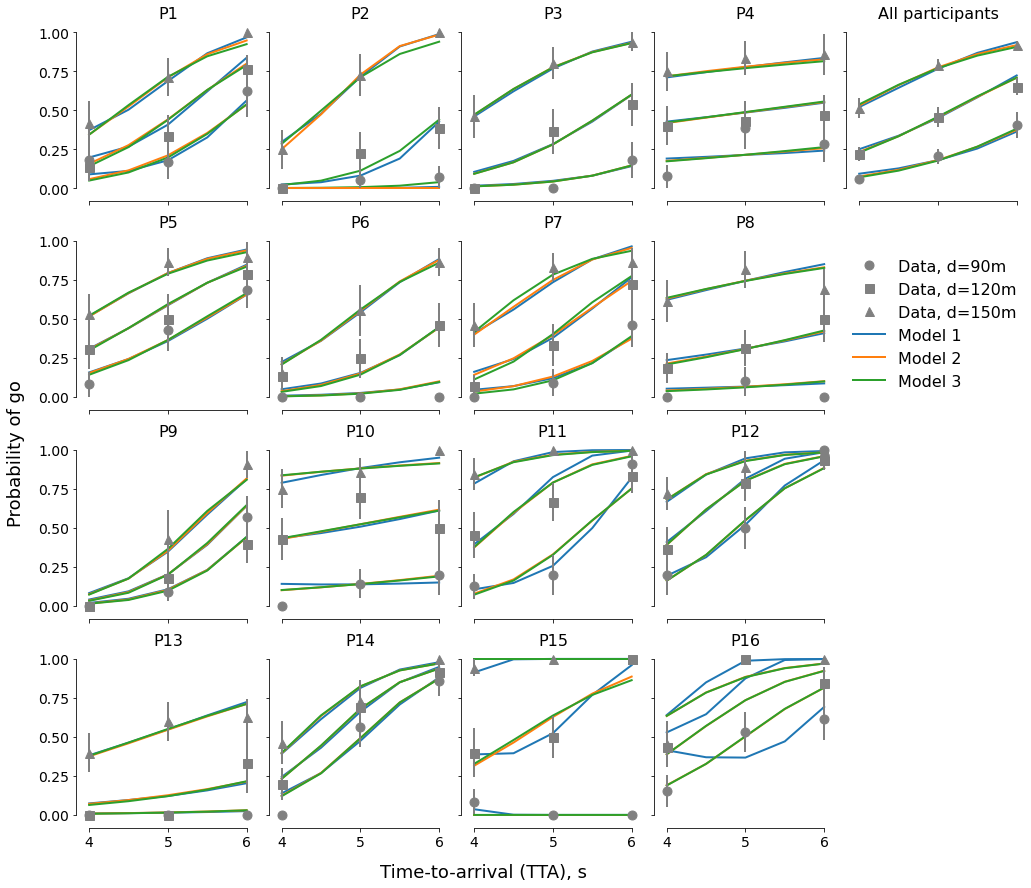

In [12]:
plot_compare_models("is_go_decision", exp_measures, "Probability of go")
plt.savefig("../output/fig_SI_models_p_go.png", bbox_inches="tight")

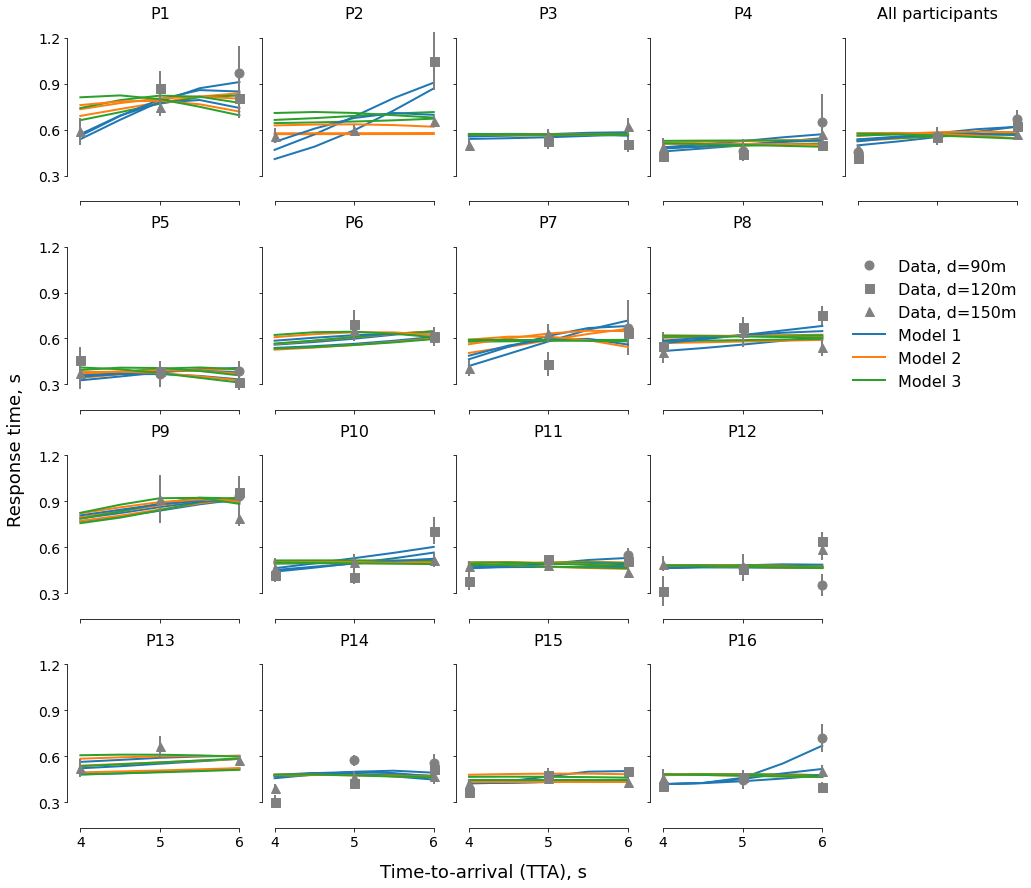

In [13]:
plot_compare_models("RT", exp_measures, "Response time, s")
plt.savefig("../output/fig_SI_models_RT.png", bbox_inches="tight")

### Full RT distributions

In [14]:
all_models_simulation_results_RT_path = "../model_fit_results/model_%i/simulation_results/full_data_rt_cdf.csv"

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_11660\1981114913.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  model_rts = pd.read_csv(all_models_simulation_results_RT_path % model_no)
C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_11660\1981114913.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  model_rts = pd.read_csv(all_models_simulation_results_RT_path % model_no)
C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_11660\1981114913.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  model_rts = pd.read_csv(all_models_simulation_results_RT_path % model_no)


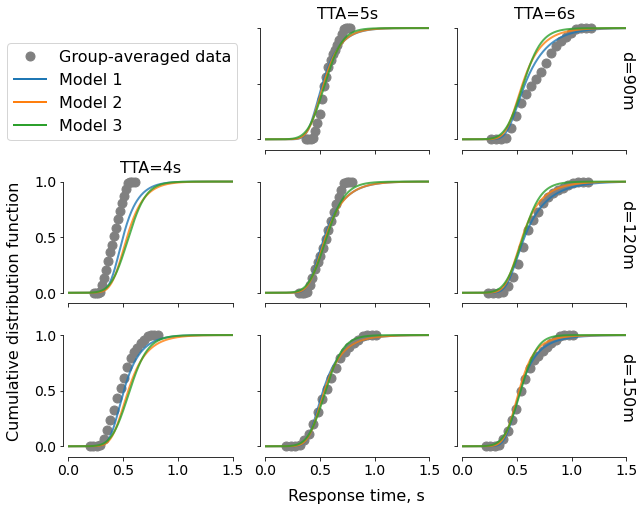

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)
for model_no in [1, 2, 3]:
    model_rts = pd.read_csv(all_models_simulation_results_RT_path % model_no)
    helper.plot_vincentized_dist(fig, axes, exp_measures, model_rts, model_color="C%i" % (model_no-1), plot_data=True if (model_no==1) else False)

legend_elements = ([Line2D([0], [0], color="grey", marker="o", ms=9, lw=0, label="Group-averaged data")]
                    + [Line2D([0], [0], color="C%i" % (model_no-1), label="Model %i" % model_no) for model_no in [1,2,3]])
fig.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0.2, 0.75), fontsize=16, frameon=True)

plt.savefig("../output/fig_SI_models_RT_dist.png", bbox_inches="tight")

### Cross-validation

## Predictive metrics

In [142]:
def get_RT_means_with_cutoff(data, groupby_cols, n_cutoff=2):
    mean = data.groupby(groupby_cols)["RT"].mean()
    # sem = data.groupby("tta_condition")[var].apply(lambda x: scipy.stats.sem(x, axis=None, ddof=0))
    n = data.groupby(groupby_cols).size()
    means = pd.DataFrame({"RT": mean, "n": n}, index=mean.index)
    return means[means.n>n_cutoff].RT

def get_data_vs_model_means(data_means, model_no=1, kind="full_data"):
    model_measures = pd.read_csv(all_models_simulation_results_path % (model_no, kind))
    model_measures = model_measures[model_measures.tta_condition.isin([4, 5, 6])
                                    & model_measures.d_condition.isin([90, 120, 150])]
    if kind=="full_data":
        model_measures = model_measures[~(model_measures.subj_id=="all")]
        model_measures["subj_id"] = pd.to_numeric(model_measures.subj_id)

    model_measures.set_index(["subj_id", "tta_condition", "d_condition"], inplace=True)

    data_vs_model = data_means.join(model_measures, lsuffix="_data", rsuffix="_model").reset_index()
    data_vs_model = data_vs_model.rename(columns={"is_go_decision_data": "p_go_data",
                                                  "is_go_decision_model": "p_go_model"})
    # data_vs_model["subj_id"] =  data_vs_model["subj_id"].astype(int)
    data_vs_model[["tta_condition", "d_condition"]] = data_vs_model[["tta_condition", "d_condition"]].astype(int)
    data_vs_model["condition"] = data_vs_model[["tta_condition", "d_condition"]].astype(str).agg("_".join, axis=1).astype(str)

    return data_vs_model

In [114]:
groupby_cols = ["subj_id", "tta_condition", "d_condition"]
subjects = exp_measures.subj_id.unique()

p_go_by_condition = exp_measures.groupby(groupby_cols).mean().is_go_decision
rt_by_condition = get_RT_means_with_cutoff(exp_measures[exp_measures.is_go_decision], groupby_cols, n_cutoff=2)
data_means = pd.DataFrame([p_go_by_condition, rt_by_condition]).T
data_means_cv = data_means.groupby(["tta_condition", "d_condition"]).mean()

### ROC of predicting probability of go decision per participant

In [115]:
def get_positive_rates(df, threshold):
    df["model_is_go_decision"] = df["p_go_model"]>threshold
    fpr = (len(df[~(df.is_go_decision==df.model_is_go_decision) & (df.model_is_go_decision)])
                   /len(df[~df.is_go_decision]))
    tpr = (len(df[(df.is_go_decision==df.model_is_go_decision) & (df.model_is_go_decision)])
                   /len(df[df.is_go_decision]))

    return (fpr, tpr)

def get_roc_curve(data_means, exp_measures, subj_id, model_no=1, kind="full_data"):
    subj_data_vs_model = exp_measures.loc[exp_measures.subj_id == subj_id,
                                          ["subj_id", "tta_condition", "d_condition", "is_go_decision"]]
    if model_no == "best_case":
        model_predictions = data_means.reset_index().rename(columns={"is_go_decision": "p_go_model"})
    else:
        data_vs_model = get_data_vs_model_means(data_means=data_means, model_no=model_no, kind=kind)
        model_predictions = data_vs_model.loc[data_vs_model.subj_id == subj_id,
                                              ["subj_id", "tta_condition", "d_condition", "p_go_model"]]
    subj_data_vs_model = (subj_data_vs_model.merge(model_predictions, on=["subj_id", "tta_condition", "d_condition"])
                 .reset_index(drop=True))
    roc = np.array([get_positive_rates(subj_data_vs_model, threshold=threshold) for threshold in np.linspace(1.001, -0.001, 21)]).T
    auc = np.trapz(y=roc[1], x=roc[0])
    return roc, auc

Best-case predictors per participant: the best theoretically possible ROC can be obtained from the estimated probabilities. By the way, the nudge-based manipulation of p_turn in the follow-up work could be linked to pushing the limits of theoretically possible prediction - if we cannot really be sure what the human will do and it might affect safety, we better sacrifice the current comfort to increase our prediction accuracy

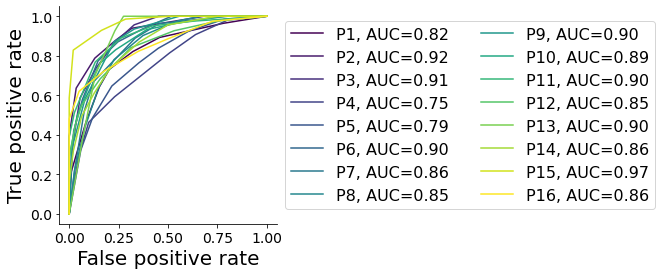

In [116]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("viridis", 16)
for subj_id, subj_idx in zip(exp_measures.subj_id.unique(), range(len(subjects))):
    roc, auc = get_roc_curve(data_means, exp_measures, subj_id, model_no="best_case")
    ax.plot(roc[0], roc[1], label="P%i, AUC=%.2f" % (subj_idx+1, auc), color=cmap(subj_idx))
    ax.set_aspect("equal")
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)
ax.set_aspect("equal")
plt.savefig("../output/fig_SI_ROC_best_case.png", bbox_inches="tight")

Comparing models by their ROC per participant

../model_fit_results/model_1/simulation_results/full_data_measures.csv
../model_fit_results/model_2/simulation_results/full_data_measures.csv
../model_fit_results/model_3/simulation_results/full_data_measures.csv
../model_fit_results/model_1/simulation_results/full_data_measures.csv
../model_fit_results/model_2/simulation_results/full_data_measures.csv
../model_fit_results/model_3/simulation_results/full_data_measures.csv
../model_fit_results/model_1/simulation_results/full_data_measures.csv
../model_fit_results/model_2/simulation_results/full_data_measures.csv
../model_fit_results/model_3/simulation_results/full_data_measures.csv
../model_fit_results/model_1/simulation_results/full_data_measures.csv
../model_fit_results/model_2/simulation_results/full_data_measures.csv
../model_fit_results/model_3/simulation_results/full_data_measures.csv
../model_fit_results/model_1/simulation_results/full_data_measures.csv
../model_fit_results/model_2/simulation_results/full_data_measures.csv
../mod

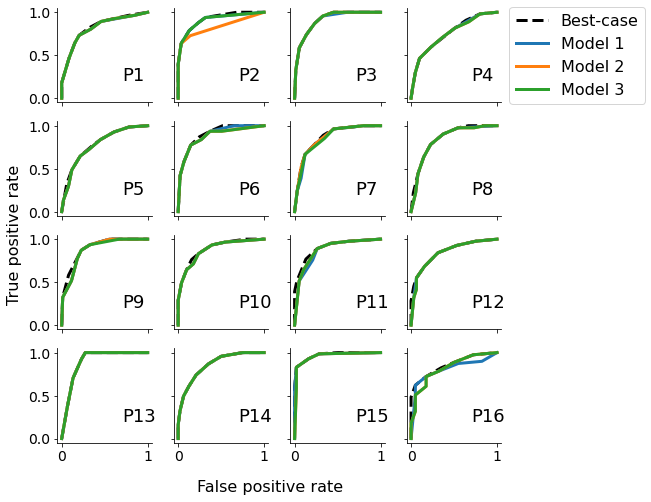

In [117]:
fig, axes = plt.subplots(4, 4, figsize=(8,8), sharex=True, sharey=True)

fig.text(0.37, 0.04, "False positive rate", fontsize=16)
fig.text(0.04, 0.37, "True positive rate", fontsize=16, rotation=90)

auc_diffs = []

for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
    ax.set_aspect("equal")

    best_case_roc, best_case_auc = get_roc_curve(data_means, exp_measures, subj_id, model_no="best_case")
    ax.plot(best_case_roc[0], best_case_roc[1], label="Best-case", ls="--", color="black", lw=3)

    subj_auc_diffs = []
    for model_no in [1, 2, 3]:
        model_roc, model_auc = get_roc_curve(data_means, exp_measures, subj_id, model_no=model_no)
        ax.plot(model_roc[0], model_roc[1], label="Model %i" % model_no, lw=3)
        subj_auc_diffs.append(best_case_auc - model_auc)

    auc_diffs.append(subj_auc_diffs)

    ax.text(0.7, 0.2, "P%i" % (subj_idx+1), fontsize=18)
    if subj_idx == 3:
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

auc_diffs = pd.DataFrame(auc_diffs, index=subjects, columns=["Model %i" % (i+1) for i in range(3)])

plt.savefig("../output/fig_SI_ROC_models.png", bbox_inches="tight")

For all three models, the difference between best-case ROC and the model ROC is small. This can also be seen in the difference between AUCs

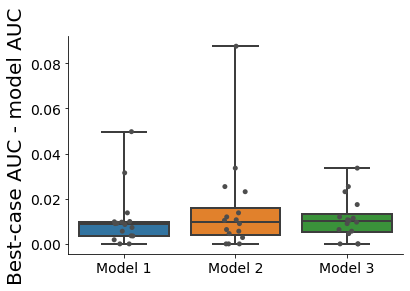

In [54]:
ax = sns.stripplot(data=auc_diffs, color=".3")
sns.boxplot(data=auc_diffs, whis=[0, 100])
ax.set_ylabel("Best-case AUC - model AUC")
plt.savefig("../output/fig_SI_AUC_diff.png", bbox_inches="tight")

### ROC for cross-validated models

In [88]:
subj_data_vs_model = exp_measures[["subj_id", "tta_condition", "d_condition", "is_go_decision"]]

In [126]:
data_vs_model_1 = get_data_vs_model_means(data_means=data_means_cv, model_no=1, kind="cross_validation_8")
model_predictions_1 = data_vs_model_1[["subj_id", "tta_condition", "d_condition", "p_go_model"]]

../model_fit_results/model_1/simulation_results/cross_validation_8_measures.csv


In [127]:
model_predictions_1

,subj_id,tta_condition,d_condition,p_go_model
0,all,4,90,0.105070
1,all,4,120,0.267871
2,all,4,150,0.507812
3,all,5,90,0.170870
4,all,5,120,0.446944
5,all,5,150,0.736011
6,all,6,90,0.313096
7,all,6,120,0.781009
8,all,6,150,0.942087


In [128]:
data_vs_model_3 = get_data_vs_model_means(data_means=data_means_cv, model_no=3, kind="cross_validation_8")
model_predictions_3 = data_vs_model_3[["subj_id", "tta_condition", "d_condition", "p_go_model"]]

../model_fit_results/model_3/simulation_results/cross_validation_8_measures.csv


In [129]:
model_predictions_3

,subj_id,tta_condition,d_condition,p_go_model
0,all,4,90,0.071470
1,all,4,120,0.234443
2,all,4,150,0.537009
3,all,5,90,0.166901
4,all,5,120,0.460808
5,all,5,150,0.752475
6,all,6,90,0.360063
7,all,6,120,0.735529
8,all,6,150,0.904020


In [130]:
subj_data_vs_model_1 = (subj_data_vs_model.merge(model_predictions_1, on=["tta_condition", "d_condition"]).reset_index(drop=True))
subj_data_vs_model_3 = (subj_data_vs_model.merge(model_predictions_3, on=["tta_condition", "d_condition"]).reset_index(drop=True))

In [132]:
subj_data_vs_model_1

,subj_id_x,tta_condition,d_condition,is_go_decision,p_go_model_x,RT,subj_id_y,p_go_model_y
0,129,4.0,90.0,True,0.056516,NaN,all,0.105070
1,129,4.0,90.0,False,0.056516,NaN,all,0.105070
2,129,4.0,90.0,False,0.056516,NaN,all,0.105070
3,129,4.0,90.0,False,0.056516,NaN,all,0.105070
4,129,4.0,90.0,False,0.056516,NaN,all,0.105070
...,...,...,...,...,...,...,...,...
1873,996,6.0,90.0,True,0.404128,0.644479,all,0.313096
1874,996,6.0,90.0,True,0.404128,0.644479,all,0.313096
1875,996,6.0,90.0,True,0.404128,0.644479,all,0.313096
1876,996,6.0,90.0,True,0.404128,0.644479,all,0.313096


In [133]:
subj_data_vs_model_3

,subj_id_x,tta_condition,d_condition,is_go_decision,p_go_model_x,RT,subj_id_y,p_go_model_y
0,129,4.0,90.0,True,0.056516,NaN,all,0.071470
1,129,4.0,90.0,False,0.056516,NaN,all,0.071470
2,129,4.0,90.0,False,0.056516,NaN,all,0.071470
3,129,4.0,90.0,False,0.056516,NaN,all,0.071470
4,129,4.0,90.0,False,0.056516,NaN,all,0.071470
...,...,...,...,...,...,...,...,...
1873,996,6.0,90.0,True,0.404128,0.644479,all,0.360063
1874,996,6.0,90.0,True,0.404128,0.644479,all,0.360063
1875,996,6.0,90.0,True,0.404128,0.644479,all,0.360063
1876,996,6.0,90.0,True,0.404128,0.644479,all,0.360063


In [101]:
def get_roc_curve_cv(data_means, exp_measures, model_no=1):
    subj_data_vs_model = exp_measures[["subj_id", "tta_condition", "d_condition", "is_go_decision"]]
    if model_no == "best_case":
        model_predictions = data_means.reset_index().rename(columns={"is_go_decision": "p_go_model"})
    else:
        data_vs_model = get_data_vs_model_means(data_means=data_means, model_no=model_no, kind="cross_validation_8")
        model_predictions = data_vs_model[["subj_id", "tta_condition", "d_condition", "p_go_model"]]
    subj_data_vs_model = (subj_data_vs_model.merge(model_predictions, on=["tta_condition", "d_condition"])
                 .reset_index(drop=True))
    roc = np.array([get_positive_rates(subj_data_vs_model, threshold=threshold) for threshold in np.linspace(1.001, -0.001, 21)]).T
    auc = np.trapz(y=roc[1], x=roc[0])
    return roc, auc

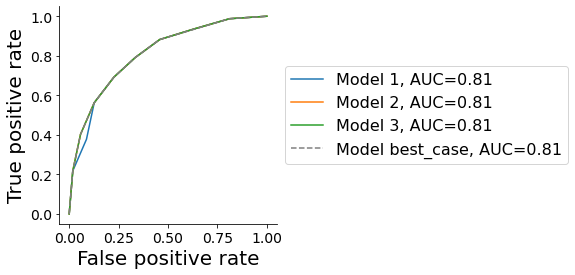

In [160]:
fig, ax = plt.subplots()
# cmap = plt.get_cmap("viridis", 16)
for model_no in [1, 2, 3, "best_case"]:
    roc, auc = get_roc_curve_cv(data_means_cv, exp_measures, model_no=model_no)
    ax.plot(roc[0], roc[1], label="Model %s, AUC=%.2f" % (str(model_no), auc),
            color="grey" if model_no=="best_case" else "C%i" % (model_no-1),
            ls="--" if model_no=="best_case" else "-")
ax.set_aspect("equal")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
ax.set_aspect("equal")
plt.savefig("../output/fig_SI_roc_cv.png", bbox_inches="tight")

### Pseudo-$R^2$

In [63]:
def plot_rt_r_squared(data_means, model_no=1):
    fig, axes = plt.subplots(4, 4, figsize=(8,8), sharex=False, sharey=False)

    fig.text(0.43, -0.01, "RT data", fontsize=20)
    fig.text(-0.01, 0.41, "RT model", fontsize=20, rotation=90)

    data_vs_model = get_data_vs_model_means(data_means=data_means, model_no=model_no, kind="full_data")
    r_squared = []
    for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
        subj_data_vs_model = data_vs_model[data_vs_model.subj_id==subj_id]
        g = sns.scatterplot(ax=ax, data=subj_data_vs_model, x="RT_data", y="RT_model",
                            color="C%i" % (model_no-1), legend=False, s=100)

        control_x = np.linspace(subj_data_vs_model.RT_data.min()-0.05, subj_data_vs_model.RT_data.max()+0.05, 2)
        ax.plot(control_x, control_x, color="grey")
        ax.set_aspect("equal")
        ax.set_xlabel("")
        ax.set_ylabel("")
        fit_metric = (1 - ((subj_data_vs_model["RT_model"]-subj_data_vs_model["RT_data"]).pow(2).sum())
                  /(subj_data_vs_model["RT_data"]-subj_data_vs_model["RT_data"].mean()).pow(2).sum())
        ax.set_title("P%i, $R^2$=%.2f" % (subj_idx+1, fit_metric), fontsize=16)
        r_squared.append(fit_metric)

    fig.suptitle("Model %i" % model_no, fontsize=24)
    plt.tight_layout()

    fig.savefig("../output/fig_SI_RT_pseudo_r_2_model_%i.png" % (model_no), bbox_inches="tight")

    return r_squared

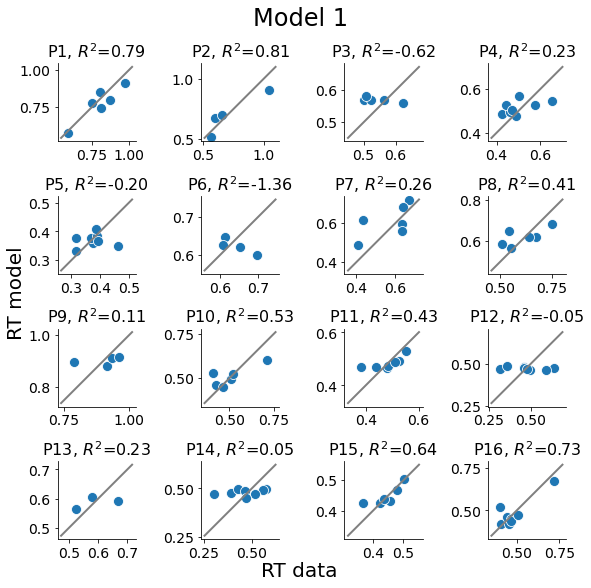

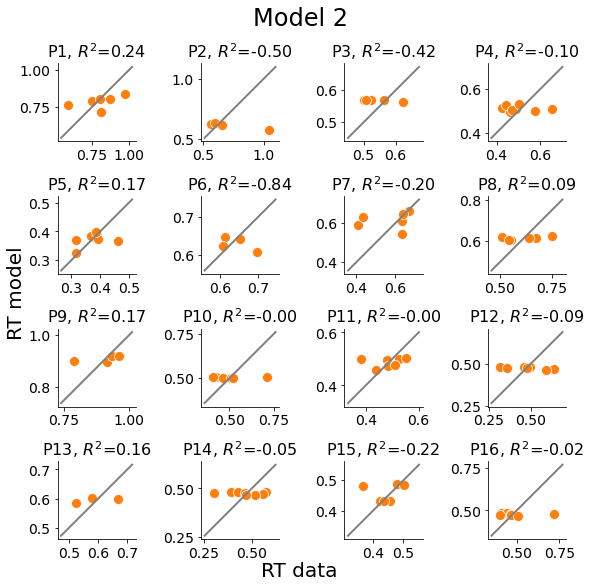

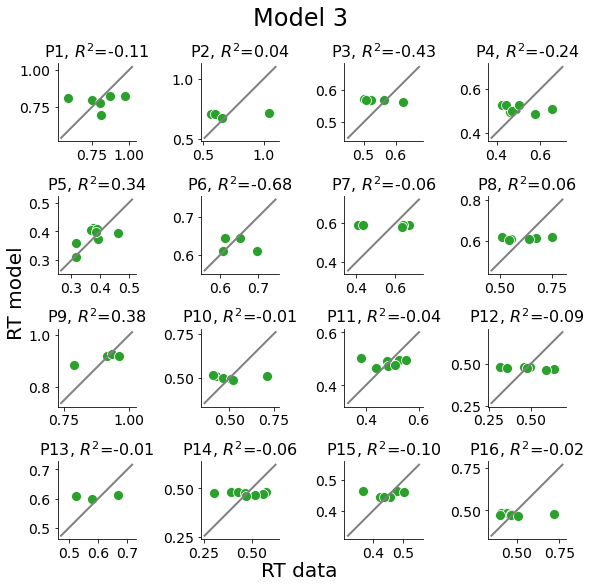

In [64]:
r_squared = pd.DataFrame([plot_rt_r_squared(data_means, model_no=model_no) for model_no in [1, 2, 3]]).T
r_squared.columns = ["Model %i" % (i+1) for i in range(3)]

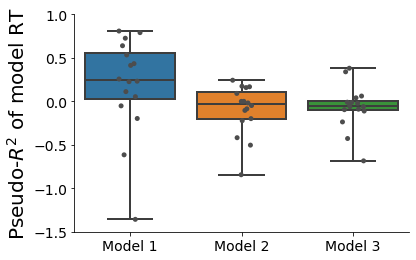

In [65]:
sns.stripplot(data=r_squared, color=".3")
sns.boxplot(data=r_squared, whis=[0, 100])
ax = plt.gca()
ax.set_ylim((-1.5, 1))
ax.set_ylabel("Pseudo-$R^2$ of model RT")
plt.savefig("../output/fig_SI_RT_pseudo_r_2_box.png", bbox_inches="tight")

### Pseudo-$R^2$ for cross-validation

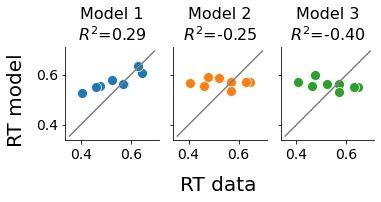

In [162]:
fig, axes = plt.subplots(1, 3, figsize=(5,3), sharex=True, sharey=True)

fig.text(0.43, 0.05, "RT data", fontsize=20)
fig.text(-0.05, 0.27, "RT model", fontsize=20, rotation=90)

for model_no, ax in zip([1, 2, 3], axes.flatten()):
    data_vs_model = get_data_vs_model_means(data_means=data_means_cv, model_no=model_no, kind="cross_validation_8")

    g = sns.scatterplot(ax=ax, data=data_vs_model, x="RT_data", y="RT_model", color="C%i" % (model_no-1), legend=False, s=100)

    control_x = np.linspace(data_vs_model.RT_data.min()-0.05, data_vs_model.RT_data.max()+0.05, 2)
    ax.plot(control_x, control_x, color="grey")
    ax.set_aspect("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    fit_metric = (1 - ((data_vs_model["RT_model"]-data_vs_model["RT_data"]).pow(2).sum())
              /(data_vs_model["RT_data"]-data_vs_model["RT_data"].mean()).pow(2).sum())
    ax.set_title("Model %s\n$R^2$=%.2f" % (model_no, fit_metric), fontsize=16)

plt.tight_layout()
plt.savefig("../output/fig_SI_RT_pseudo_r_2_cv.png", bbox_inches="tight")